## Leaf Classification Kaggle Competition
#### Alice Tang Computer Vision

This Kaggle competition (https://www.kaggle.com/competitions/leaf-classification) revolves around the challenge of classifying plant species using binary leaf images and extracted features, including shape, margin, and texture. With an estimated half a million plant species worldwide, traditional classification methods often encounter difficulties and may lead to duplicate identifications. Essentially, the goal is to accurately identify 99 different plant species. To tackle this problem, we will be using a CNN.

#### First things first, we need to load some essential packages. 

In [13]:
# Importing needed packages.  
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import seaborn as sns

#### Next, to load our data. We will be using the Kaggle environment for this competition. 

In [14]:
# Loading the data from the files. 
train_data = pd.read_csv('../input/leaf-classification/train.csv.zip')
test_data = pd.read_csv('../input/leaf-classification/test.csv.zip')

### Before we train our model and create our predictions, let's engage in some data exploration. 

#### This step will be crucial, as it will allow us to better understand the dataset and what we are working with.

In [15]:
# We'll first explore some basic information about the data.

# Displaying the first 6 columns. 
print(train_data.head())

# Displaying basic information on structure.
print(train_data.info())

   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883  

In [16]:
# Checking to see if there are any missing values.
print(train_data.isnull().sum())

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64


Luckily, there are no missing values we need to deal with. Next, we will view the summary statistics.

In [17]:
# Print the summary statistics of train data.
print(train_data.describe())

                id     margin1     margin2     margin3     margin4  \
count   990.000000  990.000000  990.000000  990.000000  990.000000   
mean    799.595960    0.017412    0.028539    0.031988    0.023280   
std     452.477568    0.019739    0.038855    0.025847    0.028411   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     415.250000    0.001953    0.001953    0.013672    0.005859   
50%     802.500000    0.009766    0.011719    0.025391    0.013672   
75%    1195.500000    0.025391    0.041016    0.044922    0.029297   
max    1584.000000    0.087891    0.205080    0.156250    0.169920   

          margin5     margin6     margin7     margin8     margin9  ...  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  ...   
mean     0.014264    0.038579    0.019202    0.001083    0.007167  ...   
std      0.018390    0.052030    0.017511    0.002743    0.008933  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   

Next, we will examine the number of species. The expected output should be 99, per the competition introduction.

In [18]:
# Count the number of species
num_classes = train_data['species'].unique().shape[0]
print("The number of classes is:", num_classes)

The number of classes is: 99


Everything looks good so far! There are 99 classes, meaning 99 species, as expected. Let's familiarize ourselves with the names of each species.

In [19]:
# Printing the list of species. 
classes = train_data['species'].unique().tolist()
print("List of classes:", classes)

List of classes: ['Acer_Opalus', 'Pterocarya_Stenoptera', 'Quercus_Hartwissiana', 'Tilia_Tomentosa', 'Quercus_Variabilis', 'Magnolia_Salicifolia', 'Quercus_Canariensis', 'Quercus_Rubra', 'Quercus_Brantii', 'Salix_Fragilis', 'Zelkova_Serrata', 'Betula_Austrosinensis', 'Quercus_Pontica', 'Quercus_Afares', 'Quercus_Coccifera', 'Fagus_Sylvatica', 'Phildelphus', 'Acer_Palmatum', 'Quercus_Pubescens', 'Populus_Adenopoda', 'Quercus_Trojana', 'Alnus_Sieboldiana', 'Quercus_Ilex', 'Arundinaria_Simonii', 'Acer_Platanoids', 'Quercus_Phillyraeoides', 'Cornus_Chinensis', 'Liriodendron_Tulipifera', 'Cytisus_Battandieri', 'Rhododendron_x_Russellianum', 'Alnus_Rubra', 'Eucalyptus_Glaucescens', 'Cercis_Siliquastrum', 'Cotinus_Coggygria', 'Celtis_Koraiensis', 'Quercus_Crassifolia', 'Quercus_Kewensis', 'Cornus_Controversa', 'Quercus_Pyrenaica', 'Callicarpa_Bodinieri', 'Quercus_Alnifolia', 'Acer_Saccharinum', 'Prunus_X_Shmittii', 'Prunus_Avium', 'Quercus_Greggii', 'Quercus_Suber', 'Quercus_Dolicholepis', 'I

We're curious in the distribution of data for each species. So let's count the number of datapoints for each one,and visualize it to make sure there is no class imbalance which could potentially affect our predictions.

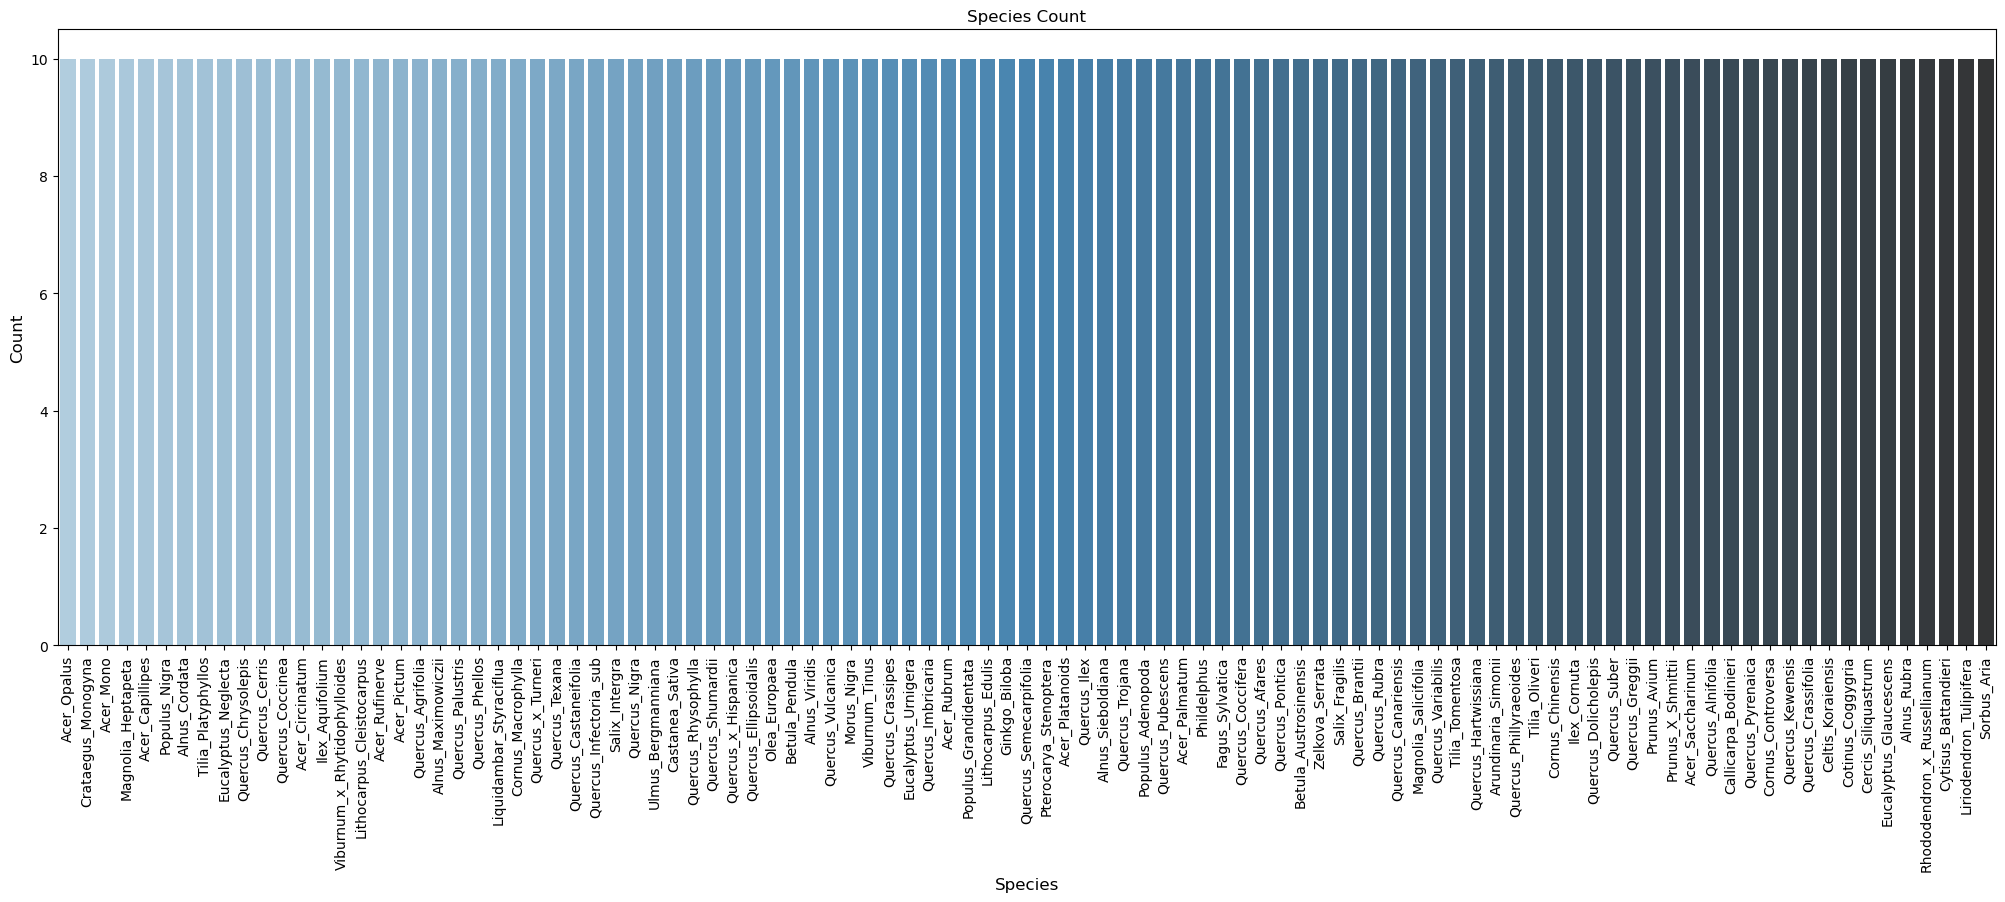

In [22]:
# Importing needed package.
import matplotlib.pyplot as plt

# Counting the number of datapoints for each species.
species_count = train_data['species'].value_counts()

# Plotting the count for every species.
plt.figure(figsize=(25,8))
sns.barplot(x = species_count.index, y = species_count.values, palette="Blues_d")
plt.title('Species Count')
plt.xticks(rotation='vertical')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.show()

As we can see here, we have 10 observations for each species, which is evenly distributed.

Next, we'll conduct some univariate analysis. We're curious to see the relationships and patterns with column names that begin with "margin", "shape", as well as "texture". 

In [24]:
# Grouping the columns by name. 
mColumns = [col for col in train_data.columns if col.startswith('margin')]
sColumns = [col for col in train_data.columns if col.startswith('shape')]
tColumns = [col for col in train_data.columns if col.startswith('texture')]

Next, we'll create some boxplots. For efficiency and visualization purposes, we'll create a function where we can customize the appearance of a boxplot. 

In [25]:
# Creating boxplot function.
def setBoxplot(ax,ylim):
    ax.set_ylim(ylim);
    ax.tick_params(axis='y',labelsize=6);
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=7);

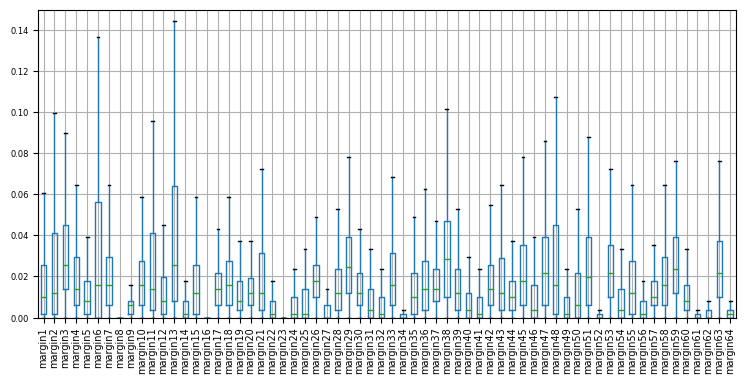

In [27]:
# Customized boxplot for "margin" columns. 
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 1, 1)
train_data[mColumns].boxplot(whis=1.5, sym='') 
setBoxplot(ax, [0, 0.15])
plt.show()

From this boxplot for "margin" columns, we can see the variability. There are columns with a wide range, as well as columns with a very narrow range.

We'll take a closer look at "margin 6". 

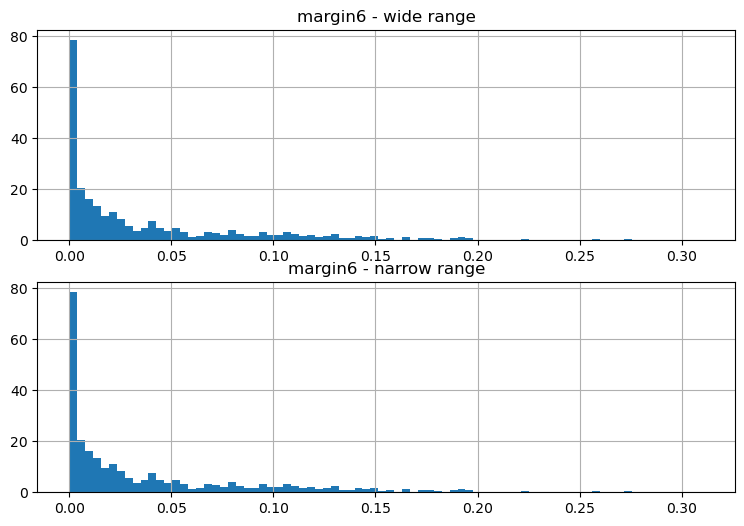

In [28]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(2, 1, 1)
train_data['margin6'].hist(bins=80, density=True);  
ax.set_title('margin6 - wide range')

ax = fig.add_subplot(2, 1, 2)
train_data['margin6'].hist(bins=80, density=True);  # Use density instead of normed
ax.set_title('margin6 - narrow range')
plt.show()


From this plot, we can see that many, if not most, of the values are zero and we can see that these are sparse vectors.

Let's examine shape next.

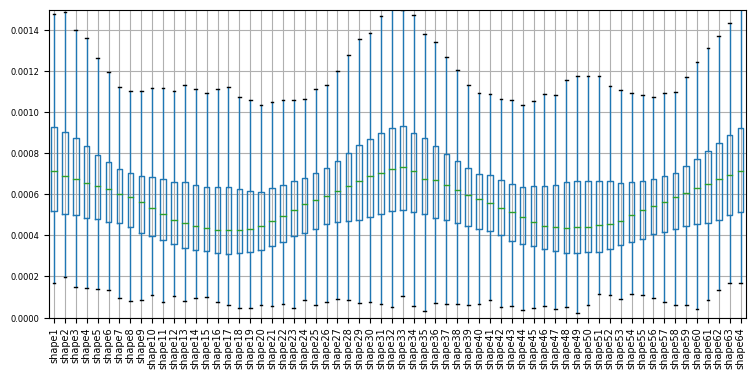

In [29]:
fig = plt.figure(figsize = (9,4));
ax = fig.add_subplot(1,1,1);
train_data[sColumns].boxplot(whis=1.5, sym='');
setBoxplot(ax,[0,0.0015])

As you can see, the IQRs for shape features remain consistently below 0.0015. This is a sign that we will need to standardize the data before we train our model. From earlier, we are able to deduce that histograms of the shape features present as symmetrical, with no apparent skewness

Lastly, let's take a look at texture.

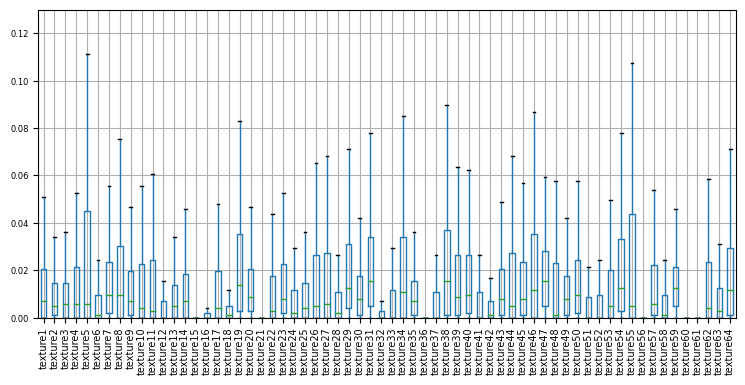

In [30]:
fig = plt.figure(figsize = (9,4));
ax = fig.add_subplot(1,1,1);
train_data[tColumns].boxplot(whis=1.5, sym='');
setBoxplot(ax,[0,0.13])

Texture features, like margin features, are sparse vectors. The majority of their interquartile ranges are below 0.03. Histograms for texture features exhibit a skew towards higher values. There is variability among these features, with some having wider ranges and others narrower. This is exemplified from the graph below, as well.

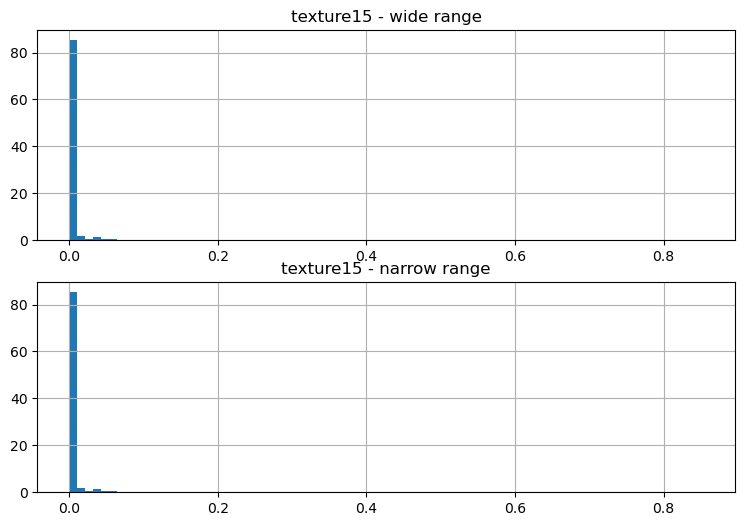

In [31]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(2, 1, 1)
train_data['texture15'].hist(bins=80, density=True);  
ax.set_title('texture15 - wide range')

ax = fig.add_subplot(2, 1, 2)
train_data['texture15'].hist(bins=80, density=True);  
ax.set_title('texture15 - narrow range')
plt.show()


Before we start creating our model, we will engage in bivariate analysis. We start by creating the definition for the correlation matrix again. 

In [48]:
def correlation_matrix(df,ax1):
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    cmap = cm.get_cmap('RdYlBu', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap, vmin=-1.0, vmax=1.0)
    ax1.grid(True)
    labels = df.columns
    ax1.set_xticks(range(0,len(labels)))
    ax1.set_xticklabels(labels,fontsize=7,rotation=90)
    ax1.set_yticks(range(0,len(labels)))
    ax1.set_yticklabels(labels,fontsize=7)
    cbar = fig.colorbar(cax)
    cbar.ax.tick_params(labelsize=7)
    ax1.grid(False)

/tmp/ipykernel_32/2146461693.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', 30)


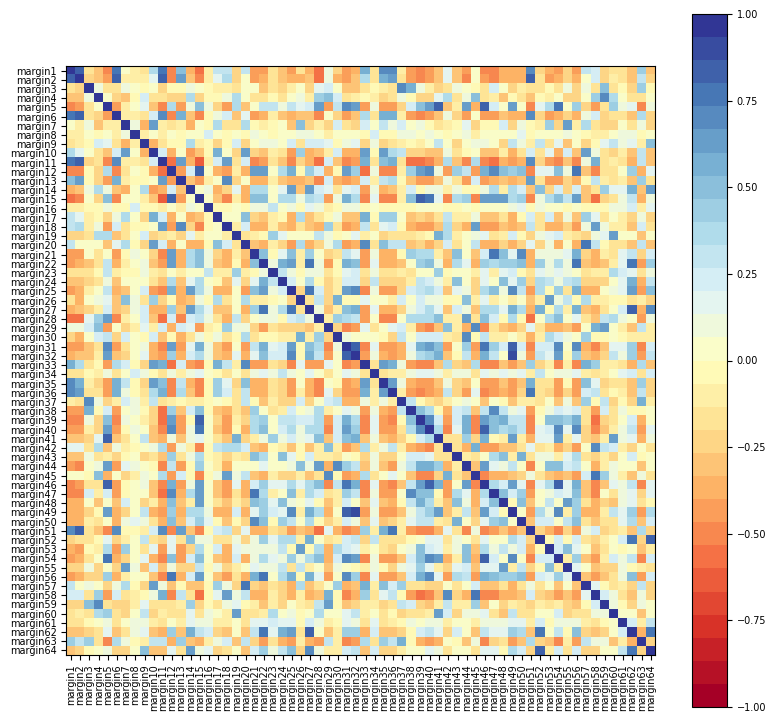

In [49]:
# Creating a correlation matrix for "margin" columns.
fig = plt.figure(figsize=(9.5,9))
ax = fig.add_subplot(1,1,1)
correlation_matrix(train_data[mColumns],ax)

We can observe from the correlation matrix that there are blocks of moderate and negative correlations between adjacent features, creating distinct clusters in the correlation matrix.

Next, we'll look at the "shape" correlation matrix.

/tmp/ipykernel_32/2146461693.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', 30)


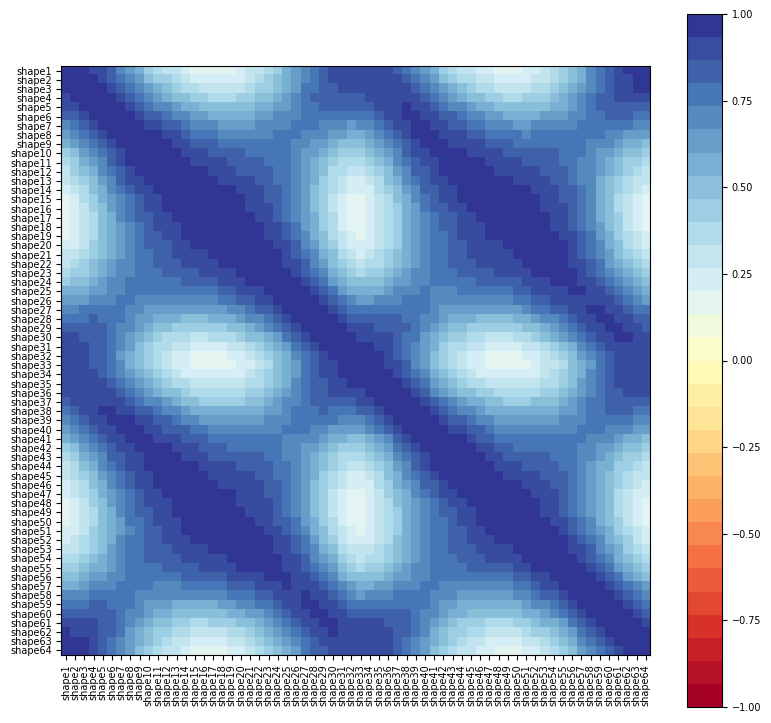

In [51]:
# Creating a correlation matrix for "shape" columns.
fig = plt.figure(figsize=(9.5,9))
ax = fig.add_subplot(1,1,1)
correlation_matrix(train_data[sColumns],ax)

Here, the correlation matrix displays high positive correlation amongst shape features.

And finally, we'll create the correlation matrix for "texture". 

/tmp/ipykernel_32/2146461693.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', 30)


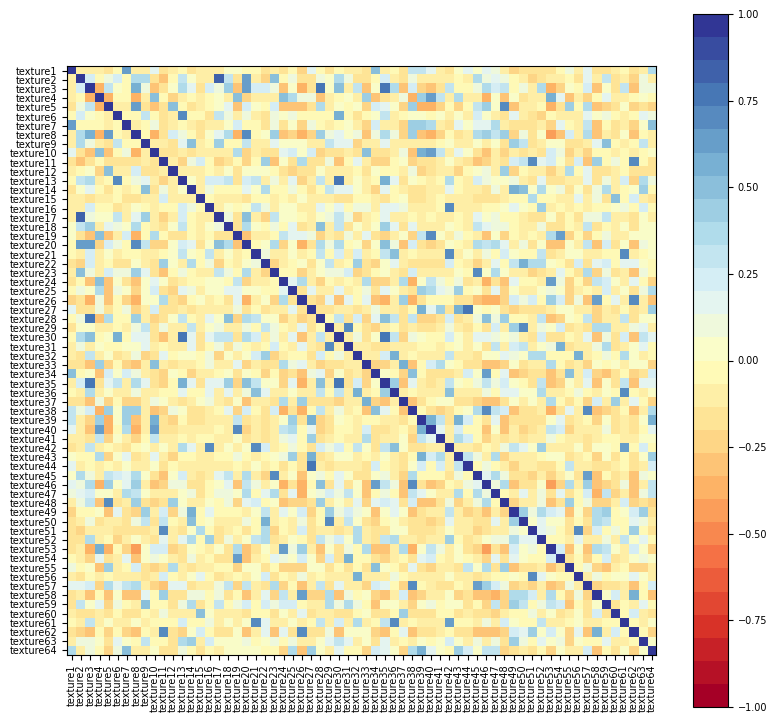

In [53]:
# Creating a correlation matrix for "texture" columns.
fig = plt.figure(figsize=(9.5,9))
ax = fig.add_subplot(1,1,1)
correlation_matrix(train_data[tColumns],ax)

From the "texture" correlation matrix, we can observe that there is generally little (whether positive or negative correlation) to no correlation between texture features. 

Great! We're ready to start preparing for our model. 

We'll begin by encoding data. This is a crucial step in preparing the data for our model, because the target variable ("species") needs to be encoded into numeric values. 

In [54]:
# Creating the encode function. 
def encode(train, test):
    label_encoder = LabelEncoder().fit(train.species) # Fitting LabelEncoder on the "species" column so we can transform the class labels into numeric values. 
    labels = label_encoder.transform(train.species) # Storing encoded labels in the variable "labels".
    classes = list(label_encoder.classes_) # Creating list of unique classes from "species" column. 

    train = train.drop(['species', 'id'], axis=1) # We are dropping species and id because they are not needed to train our model.
    test_ids=test.id
    test = test.drop('id', axis=1)

    return train, labels, test, classes,test_ids

In [55]:
# Here, we are assigning the returned values to multiple variables. 
train, labels, test, classes,test_ids = encode(train_data, test_data)

Let's check if the LabelEncoder worked.

In [56]:
# Checking if LabelEncoder worked.
test_data.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


Yep, everything looks good! The LabelEncoder was successful. We're ready to move onto the next step.

### The next step is to standardize and scale the features in the train dataset. We will do this using "StandardScaler" from scikit-learn to scale the features in the "train" dataset. 

This is a crucial preprocessing step. This ensures that features are all on a similar scale, which will prevent other features overshadowing others in the CNN we are building. Neural networks are quite sensitive to the scale of input features, so completing this step is paramount.

In [64]:
scaler = StandardScaler().fit(train.values) # Fitting StandardScaler to the data in train dataset.
scaled_train = scaler.transform(train.values) # Applying the transformation to original features in the train dataset. 

### We are now ready to split our train data into training and validation sets.

I will be using "StratifiedShuffleSplit" from scikit-learn which will create a stratified shuffled split of the data into training and validation. This ensures that class distribution is similar between training and validation sets. 

In [65]:
sss = StratifiedShuffleSplit(test_size=0.1, random_state=23) # Test size is targeting the proportion of the dataset to include in the validation set (10%).
for train_index, valid_index in sss.split(scaled_train, labels):
    X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_valid = labels[train_index], labels[valid_index]

Let's complete further data preprocessing by storing the dimensions of the feature vectors and the number of unique species in the dataset. 

In [66]:
num_features = 64 # There are 64 number of features per features type (shape, texture, margin).
num_class = len(classes)

### It's time to reshape the feature vectors for the training and validation sets into a 3D format. 

This step is crucial in preparing the data for input into a neural network, since a specific input shape is expected.

In [67]:
# Reshaping the train data.
X_train_r = np.zeros((len(X_train), num_features, 3)) # Here, we organizing the data into a 3D structure, where each of the sample has multiple sets of features. This is suitable for CNNs (3D convolutional neural networks).
X_train_r[:, :, 0] = X_train[:, :num_features]
X_train_r[:, :, 1] = X_train[:, num_features:128]
X_train_r[:, :, 2] = X_train[:, 128:]

# Reshaping the validation data.
X_valid_r = np.zeros((len(X_valid), num_features, 3)) # Repeated here.
X_valid_r[:, :, 0] = X_valid[:, :num_features]
X_valid_r[:, :, 1] = X_valid[:, num_features:128]
X_valid_r[:, :, 2] = X_valid[:, 128:]

### Great! We're officially ready to start building our CNN model. 

For this leaf classification task, I chose a CNN model because they are able to effectively capture spatial hierarchial features (unique shapes and patterns) of leaves. Regardless of where the features are on the leaves, CNNs excel in finding them anywhere. CNNs are also computationally efficient, because they excel in learning local patterns efficiently through the parameter sharing amongst the different regions of input. Additionally, CNNs automatically reduce parameter space, which allows them to be more efficient compared to other fully connected networks (which directly contrasts with CNNs).

Ultimately, with these qualities, the CNN model is a strong choice for this image classification task. However, let's put it to test, shall we? 

In [68]:
# Defining our model.
model = Sequential() # Sequential model.
model.add(Convolution1D(512, 1, input_shape=(num_features, 3))) # 1D convolutional layer with 512 filters, filter size 1, and input shape. This layer helps identify local patterns and relationships in the data.
model.add(Activation('relu')) # Using "ReLU" introduces non-linearity to the model and replaces all the ngative values in output with zero. 
model.add(Flatten())
model.add(Dropout(0.4)) # Prevents overfitting. 
model.add(Dense(2048, activation='relu')) # Dense layers help capture overall patterns and relationships. 
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class))
model.add(Activation('softmax')) # "Softmax" activation can help convert the model's output into probability scores, which is essential in multi-class classifcation problems. 

y_train = np_utils.to_categorical(y_train, num_class)
y_valid = np_utils.to_categorical(y_valid, num_class)

sgd = SGD(learning_rate=0.01, nesterov=True, decay=1e-6, momentum=0.9) # Optimized with SGD. 
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics = ["accuracy"]) # We are choosing accuracy as our evaluation metric. 

Awesome! Let's train our model.

In [69]:
# We're going to implement a checkpoint system for our best model. 
best_model_file = "leafCNN.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

nb_epoch = 15 # Training for 15 epochs. 
history = model.fit(X_train_r, y_train, epochs=nb_epoch, 
          validation_data=(X_valid_r, y_valid), 
          batch_size=16, callbacks=[best_model]) # Using best_model for our callback.

# Printing the training metrics so we are able to monitor performance. 
print('val_acc: ',max(history.history['val_accuracy']))
print('val_loss: ',min(history.history['val_loss']))
print('train_acc: ',max(history.history['accuracy']))
print('train_loss: ',min(history.history['loss']))

# Printing the train/validation loss ratio so we can gain better insight into the model's generalization performance. 
print()
print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 3.6835 - accuracy: 0.2424
Epoch 1: val_loss improved from inf to 1.54515, saving model to leafCNN.h5
56/56 [==============================] - 26s 457ms/step - loss: 3.6835 - accuracy: 0.2424 - val_loss: 1.5452 - val_accuracy: 0.6970
Epoch 2/15
56/56 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.8519
Epoch 2: val_loss improved from 1.54515 to 0.43303, saving model to leafCNN.h5
56/56 [==============================] - 26s 468ms/step - loss: 0.6619 - accuracy: 0.8519 - val_loss: 0.4330 - val_accuracy: 0.8788
Epoch 3/15
56/56 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9719
Epoch 3: val_loss improved from 0.43303 to 0.24051, saving model to leafCNN.h5
56/56 [==============================] - 26s 461ms/step - loss: 0.1347 - accuracy: 0.9719 - val_loss: 0.2405 - val_accuracy: 0.9091
Epoch 4/15
56/56 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.

Now that our model is trained, we'll repeat the process of scaling our values for the test set. 

In [70]:
scaler = StandardScaler().fit(test.values)
scaled_test = scaler.transform(test.values)

In [72]:
test_dataset = np.zeros((len(scaled_test), num_features, 3))
test_dataset[:, :, 0] = scaled_test[:, :num_features]
test_dataset[:, :, 1] = scaled_test[:, num_features:128]
test_dataset[:, :, 2] = scaled_test[:, 128:]

### We are officially ready to make predictions on our test dataset!

In [73]:
# Using the model to predict values for each sample in the test dataset.
preds_test = model.predict(test_dataset)

# Displaying the results.
preds_test

19/19 [==============================] - 1s 69ms/step


array([[1.53908303e-07, 5.20116892e-08, 9.39590183e-09, ...,
        1.33188589e-08, 6.98281792e-06, 1.28495287e-07],
       [5.74597037e-10, 8.00235256e-08, 1.15366549e-06, ...,
        1.54533200e-06, 5.82956039e-09, 1.50993529e-07],
       [7.40891366e-08, 9.98870015e-01, 5.44417347e-08, ...,
        2.26072361e-09, 1.73876522e-08, 1.61350163e-05],
       ...,
       [3.44342595e-07, 2.65524335e-07, 1.32654705e-08, ...,
        1.85333242e-08, 6.58989574e-09, 4.08223241e-06],
       [2.17713225e-09, 8.19226464e-09, 1.11328552e-06, ...,
        6.19535667e-09, 5.42898393e-10, 5.38328626e-09],
       [2.05282156e-08, 4.46825624e-07, 5.79852531e-06, ...,
        2.83558478e-07, 6.51468994e-08, 1.30663614e-06]], dtype=float32)

### Finally, we are ready to create our submission file for Kaggle!

In [74]:
# Defining the submission dataframe. 
submission = pd.DataFrame(preds_test, columns=classes)
submission.insert(0, 'id', test_ids)

# Displaying the submission frame to make sure everything looks good.
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.539083e-07,5.201169e-08,9.395902e-09,1.150637e-06,1.777732e-07,3.011074e-07,6.432090e-07,5.025459e-08,1.262729e-07,...,4.692477e-09,1.075213e-06,3.388078e-07,6.116073e-08,1.304385e-07,9.555144e-08,1.153601e-08,1.331886e-08,6.982818e-06,1.284953e-07
1,7,5.745970e-10,8.002353e-08,1.153665e-06,1.982964e-05,2.325758e-09,5.619801e-08,9.092863e-06,9.865424e-09,2.572569e-08,...,1.104298e-08,4.506671e-08,3.829359e-09,6.646018e-10,2.434082e-11,5.024215e-06,6.348019e-09,1.545332e-06,5.829560e-09,1.509935e-07
2,9,7.408914e-08,9.988700e-01,5.444173e-08,9.474550e-09,8.539067e-04,5.247668e-06,8.190821e-08,1.745496e-06,8.992522e-06,...,1.572699e-08,1.051212e-09,1.867039e-08,1.334490e-07,5.098238e-08,3.293290e-08,1.013830e-07,2.260724e-09,1.738765e-08,1.613502e-05
3,12,3.801171e-07,4.882502e-02,1.723579e-06,5.619961e-06,3.715896e-06,7.239847e-07,2.300130e-04,2.130743e-05,2.674499e-05,...,1.185581e-06,9.188965e-09,4.041476e-06,1.169786e-07,1.134462e-07,2.439458e-04,3.311123e-03,2.392536e-07,4.385263e-07,1.106427e-03
4,13,1.944122e-08,3.689083e-07,1.223766e-09,1.023451e-09,2.485077e-08,2.239919e-10,2.519517e-08,1.877323e-09,4.272015e-05,...,5.992169e-08,5.823118e-11,1.331179e-07,2.038841e-09,2.368031e-07,6.323140e-08,8.278773e-06,4.645159e-09,2.185961e-08,1.368977e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,1.041640e-07,9.997197e-01,6.325609e-08,4.453617e-09,9.031301e-05,6.264169e-07,1.902526e-08,6.129941e-07,7.293887e-06,...,1.190123e-08,1.223859e-09,1.393302e-08,4.706705e-08,1.017891e-08,7.505488e-08,2.497719e-07,2.710307e-09,1.285253e-08,9.941004e-06
590,1577,2.892607e-06,1.287259e-07,1.259977e-08,1.661462e-05,5.602250e-09,6.636563e-09,3.675828e-08,1.453298e-05,6.182407e-05,...,2.964571e-08,5.481761e-09,2.067646e-05,2.182975e-08,6.272763e-05,4.011392e-05,2.079822e-06,8.721069e-09,1.667719e-08,5.270150e-05
591,1579,3.443426e-07,2.655243e-07,1.326547e-08,4.783038e-10,4.510056e-08,2.968195e-07,1.537228e-09,4.468655e-08,9.027891e-09,...,1.022829e-10,7.185612e-11,4.531336e-08,6.634671e-08,9.795913e-08,2.137712e-10,5.626923e-10,1.853332e-08,6.589896e-09,4.082232e-06
592,1580,2.177132e-09,8.192265e-09,1.113286e-06,3.047469e-07,7.253474e-09,1.210413e-08,1.913414e-08,6.928519e-07,3.500527e-09,...,1.539150e-07,2.162273e-07,9.139319e-10,5.730741e-07,1.501748e-10,8.408755e-09,2.150980e-09,6.195357e-09,5.428984e-10,5.383286e-09


In [75]:
# Let's save our submission df as a csv so we can submit.
submission.to_csv('submission.csv', index=False)
print('done!')

done!


### After submitting, we've obtained a Kaggle score of 0.0634. The CNN model we created has a relatively good performance on this leaf classification task. For this competition, a lower score is better, and the model has done well in this task. 

##### There were multiple challenges in this task, which is natural because of the subtle visual differences between species. In turn, one can imagine that making accurate differentiation is a complex task. 

In the future, I would consider experimenting with different architectures, perhaps even incorporating pre-trained models and building upon that, to further refine my model. Additionally, the application of transfer learning could prove to be beneficial, since it can use knowledge from related tasks, overall enhancing the model's ability to capture intricate species-specific features. Furthermore, I would explore data augmentation techniques during training, as they can enhance the model's robustness through exposing it to a more diverse set of visual variations within the leaf images. 

All in all, I am pleased with the results of the CNN model!